In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import re

### Read Tiff files into npz

In [28]:
from skimage.external.tifffile import TiffFile
from skimage.io import imread, imread_collection, ImageCollection
from skimage import io
io.use_plugin('matplotlib', 'imread')


def get_image(file_name):
    """Read image from file and returns it as a tensor
    Function from deepcell.utils

    Args:
        file_name: path to image file

    Returns:
        numpy array of image data
    """
    ext = os.path.splitext(file_name.lower())[-1]
    if ext == '.tif' or ext == '.tiff':
        return np.float32(TiffFile(file_name).asarray())
    return None

def image_norm(original_image):
    # NNs prefer input data that is 0 mean and unit variance
    normed_image = (original_image - np.mean(original_image)) / np.std(original_image)
    return normed_image
    
DATA_DIR = r'/notebooks/data/RajLab_Organoid3'

In [29]:
from PIL import Image
from scipy.ndimage import zoom
from skimage.transform import resize

X_dapi = []
X_gfp = []
y_nuclei = []
y_lumens = []
y_organoid = []

xmin = np.inf
ymin = np.inf
zmax = -1

for file in sorted(os.listdir(DATA_DIR)):
    img = get_image(os.path.join(DATA_DIR, file))
    if img is None:
        continue
        
    if img.shape[1] < ymin:
        ymin = img.shape[1]
    if img.shape[2] < xmin:
        xmin = img.shape[2]
    if img.shape[0] > zmax:
        zmax = img.shape[0]
 
for file in sorted(os.listdir(DATA_DIR)):
    if re.search(".*j054.*", file):
        continue
    
    img = get_image(os.path.join(DATA_DIR, file))
    if img is None:
        continue 
    
    img = image_norm(img)
    z, y, x = img.shape
#     img = resize(img, (z, ymin, xmin))
    
    resized = []
    for frame in img:
        if re.search(".*dapi\.tif", file) or re.search(".*gfp\.tif", file):
            resized.append(Image.fromarray(frame).resize((xmin, ymin), resample=Image.LANCZOS))
        else:
            resized.append(Image.fromarray(frame).resize((xmin, ymin)))
    img = np.stack(resized)


    # Upsample 3D
    indicies = np.linspace(0, z - 1, zmax, dtype='int32')
    img = img[indicies]
    
    
    print("Processing: ", file, " ", img.shape)

    if re.search(".*dapi\.tif", file):
        X_dapi.append(img)
    elif re.search(".*gfp\.tif", file):
        X_gfp.append(img)
    elif re.search(".*lumens\.tif", file):
        y_lumens.append(img)
    elif re.search(".*nuclei\.tif", file):
        y_nuclei.append(img)
    elif re.search(".*organoid\.tif", file):
        y_organoid.append(img)
        
X_dapi = np.concatenate(X_dapi)
X_gfp = np.concatenate(X_gfp)
y_nuclei = np.concatenate(y_nuclei)
y_lumens = np.concatenate(y_lumens)
y_organoid = np.concatenate(y_organoid)

Processing:  stack_j046_i001_dapi.tif   (27, 160, 160)
Processing:  stack_j046_i001_gfp.tif   (27, 160, 160)
Processing:  stack_j046_i001_gt_lumens.tif   (27, 160, 160)
Processing:  stack_j046_i001_gt_nuclei.tif   (27, 160, 160)
Processing:  stack_j046_i001_gt_organoid.tif   (27, 160, 160)
Processing:  stack_j046_i003_dapi.tif   (28, 160, 160)
Processing:  stack_j046_i003_gfp.tif   (28, 160, 160)
Processing:  stack_j046_i003_gt_lumens.tif   (28, 160, 160)
Processing:  stack_j046_i003_gt_nuclei.tif   (28, 160, 160)
Processing:  stack_j046_i003_gt_organoid.tif   (28, 160, 160)
Processing:  stack_j046_i023_dapi.tif   (48, 160, 160)
Processing:  stack_j046_i023_gfp.tif   (48, 160, 160)
Processing:  stack_j046_i023_gt_lumens.tif   (48, 160, 160)
Processing:  stack_j046_i023_gt_nuclei.tif   (48, 160, 160)
Processing:  stack_j046_i023_gt_organoid.tif   (48, 160, 160)
Processing:  stack_j046_i027_dapi.tif   (44, 160, 160)
Processing:  stack_j046_i027_gfp.tif   (44, 160, 160)
Processing:  stack

In [31]:
print(X_dapi.shape, X_gfp.shape)

(398, 160, 160) (398, 160, 160)


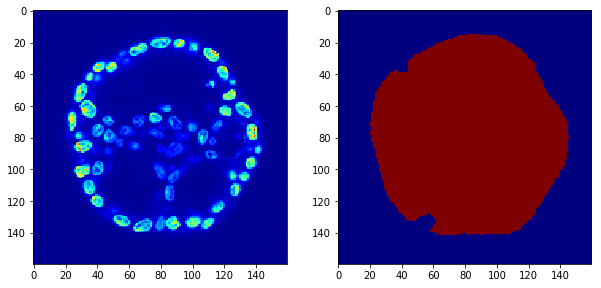

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

index = 2
frame = 20

axes[0].imshow(X_dapi[index][frame, ...], cmap='jet')
axes[1].imshow(y_organoid[index][frame, ...], cmap='jet')

plt.show()

In [32]:
print(X_dapi.shape)
n = X_dapi.shape[0]
#zmax += 2
# Reshape to add channel
X_dapi = X_dapi.reshape(n, ymin, xmin, 1)
X_gfp = X_gfp.reshape(n, ymin, xmin, 1)
y_nuclei = y_nuclei.reshape(n, ymin, xmin, 1)
y_lumens = y_lumens.reshape(n, ymin, xmin, 1)
y_organoid = y_organoid.reshape(n, ymin, xmin, 1)

# X_dapi = X_dapi.reshape(n, zmax, ymin, xmin, 1)
# X_gfp = X_gfp.reshape(n, zmax, ymin, xmin, 1)
# y_nuclei = y_nuclei.reshape(n, zmax, ymin, xmin, 1)
# y_lumens = y_lumens.reshape(n, zmax, ymin, xmin, 1)
# y_organoid = y_organoid.reshape(n, zmax, ymin, xmin, 1)

(398, 160, 160)


In [25]:
superimposed = X_dapi + X_gfp
print(superimposed.shape)

(398, 160, 160, 1)


In [34]:
NPZ_PATH = os.path.join(DATA_DIR, 'npz')
path = os.path.join(NPZ_PATH, 'organoid_data_no54_zmax.npz')

In [35]:
np.savez(path, X_dapi=X_dapi, X_gfp=X_gfp, y_nuclei=y_nuclei, y_lumens=y_lumens, y_organoid=y_organoid)

In [39]:
NPZ_PATH = os.path.join(DATA_DIR, 'npz')
path = os.path.join(NPZ_PATH, 'organoid_lumens_superimposed.npz')

In [40]:
np.savez(path, X=superimposed, y=y_lumens)

3


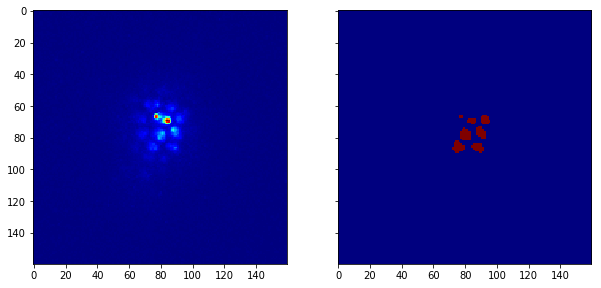

In [131]:
import matplotlib.pyplot as plt

organoid_data = np.load(path)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)

index = np.random.randint(low=0, high=X_dapi.shape[0])
print(index)
index = 2
frame = 0
axes[0].imshow(organoid_data['X_dapi'][index, frame, ..., 0], cmap='jet')
axes[1].imshow(organoid_data['y_nuclei'][index, frame, ..., 0], cmap='jet')

plt.show()